# Insights from the European Social Survey 8

In this full-stack data science project, we will analyze the 8th European Social Survey. After a contextual [introduction](#introduction), we will start with [data selection and cleaning](#data), followed by interactive [visualization and exploration](#viz). In the second half of the project, we will gain deeper insights by employing [statistical inference](#stats) and [machine learning](#ml) methods.

## Introduction <a id="introduction"></a>
Europe is a vast and diverse continent and its population is a fascinating subject for sociological studies. The [European Social Survey](https://www.europeansocialsurvey.org/) provides great data sets for exactly that purpose. According to their own description, *"The European Social Survey (ESS) is an academically driven cross-national survey that has been conducted across Europe since its establishment in 2001. Every two years, face-to-face interviews are conducted with newly selected, cross-sectional samples. The survey measures the attitudes, beliefs and behaviour patterns of diverse populations in more than thirty nations."*. This data set contains the results of the 8th round of the ESS surveyed in 2016/17.

We may wonder, how do the citizens of European countries think about certain social issues?  What about climate change, politics, immigration, individual well-being? How do people's opinions and beliefs differ within a country or among the countries? I'm personally interested in these questions because I have been roaming around Asia for a long time but soon I may return to Europe. I've been quite disconnected from my home country but I heard the horror stories about anti-democratic political parties on the rise, anti-immigration tendencies, people denying climate change, and so on. One can easily get the impression from the media that many unhappy or dissatisfied about a lot of things. That's scary enough to make me want to check some actual numbers instead of listening to all the flashy headlines. Follow along while I dig into this data set to see what I should expect when I get back home to Europe soon. Oh, one more thing before we start: for whatever reason Israel took part in this survey; last time I checked Israel was not in Europe, but hey, welcome on board friends.

## Table of contents
1. [Introduction](#introduction)
2. [Data selection and cleaning](#data)
3. [Exploration and visualization](#viz)
    *  [Creating the visualization](#viz1)
    *  [Exploring trends](#viz2)         
4. [Hypothesis testing and effect sizes](#stats)
    * [Theoretical background](#stats1)
    * [Performing tests](#stats2)
5. [Predicting answers with machine learning](#ml)
    * [Data preparation](#ml1)
    * [Interpretation of linear models](#ml2)
    * [Interpretation of gradient-boosted ensembles](#ml3)
6. [Conclusion](#conclusion)

## Data selection and cleaning <a id="data"></a>
Load the libraries we'll need and have a look at the data files.

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import scipy.stats # statistical functions
# plotting
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")
%matplotlib notebook

# avoid displaying warnings in notebook (still visible in console)
import warnings
warnings.filterwarnings('ignore')

# Input data files are available in the "../input/" directory.
# list all files under the input directory
print("Files in this folder:")
import os
for dirname, _, filenames in os.walk('./'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

Files in this folder:
./ESS8e02.1_F1.csv
./insights-from-the-european-social-survey.ipynb
./variables.csv
./ESS8e02.1.pdf
./.ipynb_checkpoints/insights-from-the-european-social-survey-checkpoint.ipynb
./figures/hist2.png
./figures/box.png
./figures/hist3.png
./figures/hist1.png


In [2]:
# start with loading all available data into a data frame
df = pd.read_csv("./ESS8e02.1_F1.csv")
print("That's all the data:")
df.info()

That's all the data:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44387 entries, 0 to 44386
Columns: 534 entries, name to pweight
dtypes: float64(226), int64(298), object(10)
memory usage: 180.8+ MB


We can see that we are dealing with a fairly large data set. The 534 columns each represent one variable corresponding to a question asked in the survey. We have 44387 rows, each corresponding to one surveyed person. 

When dealing with a lot of numbers, it can be too easy to forget what is actually behind them - so at this point we should remind ourselves that each of these rows corresponds to a real human being who took the time for this survey. A human who answered all these questions, some of which were probably hard to reflect on. And in some of these rows, we will probably be able to read some really sad stories and personal tragedies. We should be grateful towards these people and appreciate their contribution to our scientific understanding, and we should use the knowledge we gain from this data to contribute to the well-being of all people.

Now, regarding the **data selection and cleaning**, there is a lot to do before we can use the data properly, so let's go through some important points:
- The variables are grouped in topics such as media and social trust, politics, subjective well-being, social issues, climate change etc. which contain important infomation for us, but also administrative variables (such as interview dates) and interview code variables which I will not consider here. There are also variables for specific countries (e.g. about specific political parties) which I will not consider either.
- There are sampling stratification weights for each person and population weights for each country given which should usually be applied when calculating average aggregated values. I will not use them here though, because I am also interested in the whole distribution of the data, the spread of answers given, and multiplying these weights would greatly distort individuals' responses.
- The ordinal answers to questions are not all on the same scale (e.g. 1 to 5 vs. 0 to 10) and some of the scales seem to be in reverse order with respect to how the corresponding question was phrased. Maybe this was done to avoid leading questions in the survey. I will reverse the order of these scale when it makes sense to me. Please refer to the survey documentation for more details.
- Invalid answers (e.g. refusal, don't know, missing) are sometimes encoded with numbers 66, 77, 99 for the larger scales, sometimes with 6, 7, 8, 9 for the smaller scales, sometimes it's mixed. Generally, there are a lot of different ways of how the question encoding was designed. This  may be the result of many different groups of people working on this survey.

Due to this many quite specific tasks, I manually went through the documentation, retrieved (hopefully) all the information needed for the cleaning, and saved it in a file named `variables.csv`. Let's load this file first.

In [3]:
all_variables = pd.read_csv("./variables.csv")
all_variables.sample(10)

,Name,Label,Country_specific,Scale_type,Type,Format,Valid,Invalid,Question,Group
304,edlveat,"Highest level of education, Austria",yes,nominal,discrete,numeric-4.0,2007,42380,F15AT What is the highest level of education y...,Group Socio-demographics
135,rlgdehu,Religion or denomination belonging to in the p...,yes,nominal,discrete,numeric-4.0,52,44335,C14HU Which one? (Hungary),"Group Subjective well-being, social exclusion,..."
156,dscroth,Discrimination of respondent's group: other gr...,no,binary,discrete,numeric-1.0,44387,0,C19 On what grounds is your group discriminate...,"Group Subjective well-being, social exclusion,..."
197,ccnthum,"Climate change caused by natural processes, hu...",no,ordinal,discrete,numeric-2.0,42234,2153,D22 Do you think that climate change is caused...,Group Climate change
280,rshipa6,Sixth person in household: relationship to res...,no,nominal,discrete,numeric-2.0,1374,43013,"F46 Looking at this card, what relationship is...","Group Gender, Year of birth and Household grid"
455,edlvfdse,"Father's highest level of education, Sweden",yes,nominal,discrete,numeric-4.0,1390,42997,F52SE What is the highest level of education y...,Group Socio-demographics
89,gincdif,Government should reduce differences in income...,no,ordinal,discrete,numeric-1.0,43715,672,"B33-36 Using this card, please say to what ext...",Group Politics
220,sblazy,Social benefits/services make people lazy,no,ordinal,discrete,numeric-1.0,43356,1031,E13-14 And to what extent do you agree or disa...,Group Welfare attitudes
44,prtvtdpl,"Party voted for in last national election, Poland",yes,nominal,discrete,numeric-2.0,1048,43339,B14PL Which party did you vote for in that ele...,Group Politics
7,ppltrst,Most people can be trusted or you can't be too...,no,ordinal,discrete,numeric-2.0,44272,115,"A4 Using this card, generally speaking, would ...",Group Media and social trust


There we got the variables with their names and a short version of the question as a label. We can see if they are continious or discrete, ordinal or nominal or binary. I am interested in seeing trends so I want to focus on the questions with an ordinal scale (some thing like *"On a scale of 0 to 10, how much do you agree with..."*). The binary yes-or-no questions are not so useful for my purpose so I won't consider them. I will also not consider the nominal answers (e.g. occupation, educational degree, political party voted for, country of birth, maritial status etc.) with a few exceptions: I want to see differences among the countries (`cntry`) and among genders (`gndr`, only 9 people in the whole survey did not categorize themselves as either male or female so we will consider only these two genders here). I will also include the continious variables age (`agea`), years of full-time education completed (`eduyrs`), daily news consumption in minutes (`nwspol`), daily internet usage in minutes(`netustm`).

In [4]:
# get the variables that are not country specific, ordinal, and not part of the admistrative group
ordinal = all_variables.query("Country_specific == \"no\" & Scale_type == \"ordinal\" and Group != \"Group Administrative variables\"")

# get the continous variables mentioned above 
continious = all_variables.query( "Name in [\"agea\",\"eduyrs\",\"nwspol\",\"netustm\"]")

# get the nominal variables mentioned above 
nominal = all_variables.query( "Name in [\"cntry\",\"gndr\"]")

# append them to one data frame
variables = pd.concat([nominal,continious,ordinal]).reset_index(drop=True)
variables.head(10)

,Name,Label,Country_specific,Scale_type,Type,Format,Valid,Invalid,Question,Group
0,cntry,Country,no,nominal,discrete,character-2,44387,0,5 Country,Group Country
1,gndr,Gender,no,nominal,discrete,numeric-1.0,44378,9,"F21 CODE SEX, respondent","Group Gender, Year of birth and Household grid"
2,nwspol,"News about politics and current affairs, watch...",no,continuous,continuous,numeric-4.0,43863,524,"A1 On a typical day, about how much time do yo...",Group Media and social trust
3,netustm,"Internet use, how much time on typical day, in...",no,continuous,continuous,numeric-4.0,30113,14274,"A3 On a typical day, about how much time do yo...",Group Media and social trust
4,agea,"Age of respondent, calculated",no,continuous,continuous,numeric-4.0,44232,155,"F31b Age of respondent, calculated","Group Gender, Year of birth and Household grid"
5,eduyrs,Years of full-time education completed,no,continuous,continuous,numeric-2.0,43963,424,F16 About how many years of education have you...,Group Socio-demographics
6,netusoft,"Internet use, how often",no,ordinal,discrete,numeric-1.0,44338,49,A2 People can use the internet on different de...,Group Media and social trust
7,ppltrst,Most people can be trusted or you can't be too...,no,ordinal,discrete,numeric-2.0,44272,115,"A4 Using this card, generally speaking, would ...",Group Media and social trust
8,pplfair,"Most people try to take advantage of you, or t...",no,ordinal,discrete,numeric-2.0,44072,315,"A5 Using this card, do you think that most peo...",Group Media and social trust
9,pplhlp,Most of the time people helpful or mostly look...,no,ordinal,discrete,numeric-2.0,44211,176,A6 Would you say that most of the time people ...,Group Media and social trust


Now we've got all the variables we need. The `Format` column contains the values `numeric-1.0`,`numeric-2.0`, and `numeric-4.0` which tells us how many digits the variable's value can have at most. This will be useful for removing invalid answers as they should be encoded as values >= 6, 66, or 6666, respectively. We should be fine with removing everything that is above 5 for the small ordinal scales and above 10 for the large ordinal scales. An exception are the questions in the group "Human Values", which include 6 as a valid answer in a 1 to 6 scale and start their invalid answers >= 7. You can see from this example that real world data can be really messy and that it is important to pay attention to the details.

In [5]:
# get the variable names grouped by the way they have encoded invalid answers
humval = variables.query("Group == \"Group Human values\"").Name
num1 = variables.query("Format == \"numeric-1.0\" & Group != \"Group Human values\" ").Name
num2 = variables.query("Format == \"numeric-2.0\" & Name != \"eduyrs\" ").Name
edy = ["eduyrs"]
num4 = variables.query("Format == \"numeric-4.0\" ").Name

Let's now select the variables we chose from the whole data set.

In [6]:
# drop the 9 people who are neither male nor female
df = df[df.gndr<=2]

# select all the variables that we chose above
ess = df[variables.Name]
ess.sample(10)

,cntry,gndr,nwspol,netustm,agea,eduyrs,netusoft,ppltrst,pplfair,pplhlp,...,iphlppl,ipsuces,ipstrgv,ipadvnt,ipbhprp,iprspot,iplylfr,impenv,imptrad,impfun
19040,GB,1,30,240,31,15,5,2,4,5,...,2,2,2,2,2,2,2,2,3,3
39939,RU,1,30,120,42,15,5,5,5,5,...,3,2,4,4,3,3,5,2,3,2
20347,GB,1,0,180,38,12,5,3,3,3,...,4,5,5,4,4,4,4,3,5,3
22037,IE,2,0,6666,52,12,1,2,4,6,...,4,4,4,3,5,2,3,4,6,4
7064,CZ,1,30,60,35,12,4,5,6,3,...,3,3,1,4,2,5,2,1,2,4
15518,FI,1,5,300,17,10,5,8,8,7,...,1,6,2,4,4,2,3,1,1,1
14499,FI,1,60,120,55,17,5,4,6,4,...,2,4,2,4,3,5,2,3,5,2
33884,NL,2,60,180,19,13,5,7,7,8,...,2,4,3,5,4,4,2,3,5,3
1136,AT,2,0,45,28,12,4,7,7,8,...,3,2,2,3,4,2,1,4,3,2
6908,CZ,1,60,180,40,13,5,6,5,5,...,2,3,4,2,2,3,2,3,4,6


In [7]:
# check for missing values 
print(f"Missing values: \n{ess.isna().sum()[ess.isna().sum() > 0]}")

Missing values: 
rfgfrpc    1614
eusclbf    8931
eudcnbf    8931
lknemny    2010
dtype: int64


Look's great. We already have some missing values present in the variables:
- `rfgfrpc`: Most refugee applicants not in real fear of persecution own countries
- `eusclbf`: Against or In favour of European Union-wide social benefit scheme
- `eudcnbf`: More decisions made by EU: level of benefits in \[country\] become higher or lower
- `lknemny`: How likely not enough money for household necessities next 12 months

We will now add many more missing values by replacing the invalid response encodings with NaNs. These will later, in visualization or models, either be ignored/dropped or imputed.

In [8]:
# replace invalid responses (discussed above) with NaN
for group, cutoff in zip([humval,num1,num2,edy,num4],[7,6,11,66,6666]):
    for var in group:
        ess.loc[:,var].where(ess[var]<cutoff,other=np.nan,inplace=True)


In [9]:
# check for missing values again
print(f"Missing values after removing invalid answers:\n{ess.isna().sum()[ess.isna().sum() > 0]}") 

Missing values after removing invalid answers:
nwspol        524
netustm     14272
eduyrs        421
netusoft       49
ppltrst       115
pplfair       315
pplhlp        176
polintr        97
psppsgva      956
actrolga      933
psppipla      840
cptppola      997
trstprl       873
trstlgl       849
trstplc       320
trstplt       645
trstprt       855
trstep       3459
trstun       3457
prtdgcl     25315
lrscale      5803
stflife       186
stfeco        885
stfgov       1160
stfdem       1488
stfedu       1568
stfhlth       316
gincdif       670
mnrgtjb       498
freehms      1201
            ...  
lkuemp      10284
lknemny      3773
hhmmb         130
domicil        47
estsz        4940
wkdcorga     3881
iorgact      4086
hinctnta     7938
hincfel       519
ipcrtiv       841
imprich       787
ipeqopt       814
ipshabt       890
impsafe       740
impdiff       819
ipfrule      1015
ipudrst       876
ipmodst       852
ipgdtim       810
impfree       790
iphlppl       795
ipsuces       922

Great, looks like we have replaced all invalid answers with NaN. Now let's reverse the scales that have to be reversed. I have prepared a list with the corresponding variables. If you want to check if you'd agree with my decision to reverse them, please look them up in the survey's documentation. There also is a variable named `lrscale` which represents the placement on the political left-right scale where 0 means very left and 10  means very right. It doesn't have to be reversed since the corresponding question is just *"In politics people sometimes talk of 'left' and 'right'. \[...\] Where would you place yourself on this scale \[...\]?"*. I just want mention it here in case someone wonders.

In [10]:
# list of variable for which the scale seems reversed with 
# respect to how the according question wa phrased
reverse = ["ipcrtiv", "imprich", "ipeqopt", "ipshabt", "impsafe", "impdiff", "ipfrule", 
           "ipudrst", "ipmodst", "ipgdtim", "impfree", "iphlppl", "ipsuces", "ipstrgv", 
           "ipadvnt", "ipbhprp", "iprspot", "iplylfr", "impenv", "imptrad", "impfun", 
           "prtdgcl", "gincdif", "mnrgtjb", "freehms", "hmsfmlsh", "hmsacld", "imsmetn", 
           "imdfetn", "impcntr", "aesfdrk", "health", "hlthhmp", "rlgatnd", "pray", 
           "gvrfgap", "rfgfrpc", "rfgbfml", "elgcoal", "elgngas", "elghydr", "elgnuc", 
           "elgsun", "elgwind", "elgbio", "clmchng", "ccgdbd", "inctxff", "sbsrnen", 
           "banhhap", "dfincac", "smdfslv", "sbstrec", "sbprvpv", "sbeqsoc", "sbbsntx", 
           "sblazy", "sblwcoa", "imsclbn","uentrjb", "lbenent", "bennent", "eudcnbf",
           "domicil", "hincfel"]

# reverse the ranges
for var in reverse:
    upp = int(ess[var].max())
    low = int(ess[var].min())
    ess[var].replace(dict(zip(range(low,upp+1),range(upp,low-1,-1))),inplace=True)

Great! So, in case that whatever we do next can handle NaNs, we are done with the wrangling for now!

In [11]:
ess.sample(10)

,cntry,gndr,nwspol,netustm,agea,eduyrs,netusoft,ppltrst,pplfair,pplhlp,...,iphlppl,ipsuces,ipstrgv,ipadvnt,ipbhprp,iprspot,iplylfr,impenv,imptrad,impfun
16055,FI,1,10.0,30.0,70,16.0,5.0,8.0,8.0,8.0,...,5.0,5.0,6.0,3.0,6.0,3.0,6.0,5.0,3.0,5.0
28250,IT,2,0.0,NaN,69,13.0,1.0,6.0,4.0,4.0,...,4.0,3.0,NaN,1.0,NaN,NaN,4.0,NaN,4.0,NaN
13848,ES,1,90.0,240.0,23,8.0,5.0,4.0,4.0,4.0,...,6.0,3.0,5.0,4.0,6.0,3.0,6.0,5.0,2.0,3.0
27020,IL,2,60.0,240.0,22,16.0,5.0,3.0,3.0,5.0,...,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,5.0,6.0
17726,FR,2,90.0,120.0,60,12.0,5.0,7.0,8.0,7.0,...,6.0,6.0,6.0,2.0,6.0,3.0,6.0,6.0,4.0,5.0
2047,BE,2,75.0,90.0,34,13.0,5.0,3.0,3.0,5.0,...,5.0,4.0,5.0,4.0,4.0,1.0,5.0,5.0,4.0,4.0
29204,IT,1,60.0,240.0,57,18.0,5.0,3.0,5.0,3.0,...,5.0,5.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0
19344,GB,1,60.0,600.0,38,17.0,5.0,7.0,5.0,7.0,...,4.0,3.0,5.0,4.0,2.0,2.0,5.0,5.0,2.0,3.0
3355,BE,1,150.0,NaN,74,6.0,1.0,3.0,4.0,5.0,...,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0
42349,SE,1,420.0,180.0,51,13.0,5.0,10.0,10.0,8.0,...,5.0,3.0,2.0,3.0,4.0,3.0,5.0,4.0,3.0,4.0


## Exploration and visualization <a id="viz"></a>
Now that we got the data cleaned, we want to find out what story it tells. We want to see what people answered to all these questions, how these answers differ by country or gender, and how the answers to some questions correlate with the answers to other questions. Which country is the happiest? Who feels the most trust in politics, feels most responsible for climate change, and do  women and men have different opinions on it? 

The best way to explore such questions is to visualize them in an interactive way so that we can click around, select different variables, and graphically see how the responses differ between the countries. I've written a `ess_plot()` function below, which creates such an interactive visualization using Python's Bokeh library. Feel free to read all the code, but if you find it too boring just click [here](#next) to jump to the next cell.

### Creating the visualization <a id="viz1"></a>

In [12]:
def ess_plot(var1="health",var2="happy"):
    """
    This function creates an interactive graphic visualizing  insights from th ESS8.
    It consists of three sub-plots:
       - A line graph that shows the median of one variable as a function of (discrete bins) of another variable.
         This chart can be filtered by country.
       - A bar chart that shows the mean of  the first variable for each country
       - A bar chart that shows the mean of  the second variable for each country
    Hovering over the graphs will display values in detail.
    
    Parameters
    ----------
    var1, var2 : string
            Names of the two variables to compare initially. 
            (variables can be changed interactively in the plot)

    Returns
    -------
    No returns
    """
    import math
    from bokeh.plotting import figure 
    from bokeh.io import output_notebook, show, push_notebook
    output_notebook()
    from bokeh.models import Band
    from bokeh.models import Range1d
    from bokeh.models import FactorRange
    from bokeh.models import HoverTool
    from bokeh.models import ColumnDataSource
    from bokeh.layouts import row
    from ipywidgets import interact
    
    # width and height for subplots
    p_width ,p_height = 380, 450
    
    #  X and Y variable values
    x = var1#"health"
    y = var2#"happy"
    # country filter variable and dictionary 
    cntry = "All countries"
    cntry_dict = dict(zip(
                          ["All countries","Austria","Belgium","Switzerland","Czech republic","Germany","Estonia","Spain",
                           "Finland","France","United Kingdom","Hungary","Ireland","Israel","Iceland","Italy","Lithuania",
                           "Netherlands","Norway","Poland","Portugal","Russia","Sweden","Slovenia"],
                          ["All countries",'AT', 'BE', 'CH', 'CZ', 'DE', 'EE', 'ES', 'FI', 'FR', 'GB', 'HU','IE', 'IL', 
                           'IS', 'IT', 'LT', 'NL', 'NO', 'PL', 'PT', 'RU', 'SE','SI']))
    
    # boolean False for first setup, later True when plot is updated
    setup = False
    # h is a notebook handle which will be inistialized later and used for updating the plot
    global h
    h = None
    
    def calc_median_iqr():
        """Calculates medians and quartiles for plotting"""
        nonlocal x
        nonlocal y
        nonlocal cntry
        
        # get a copy of the variable columns we want to look at
        if cntry == "All countries":
            ess_c = ess[[x,y]].copy()
        else:
            c = cntry_dict[cntry]
            ess_c = ess.query("cntry == @c")[[x,y]].copy()
        
        # get the y-range
        yrange = (ess_c[y].min(),ess_c[y].max())
        
        # jitter the y-values
        ess_c[y] = ess_c[y] + np.random.uniform(-0.5,0.5,len(ess_c[y]))
        
        # remove NaNs from x-values because bokeh apparently has a problem converting them to JSON
        xs = sorted([n for n in ess_c[x].unique() if not math.isnan(n)])
        
        # get x-range
        xrange = (min(xs),max(xs))
        
        # calculate the median, first, and third quartile of the y-values for each x-value
        medians = [ess_c.loc[ess_c[x]==i,y].median() for i in xs]
        Q3 = [ess_c.loc[ess_c[x]==i,y].quantile(0.75) for i in xs]
        Q1 = [ess_c.loc[ess_c[x]==i,y].quantile(0.25) for i in xs]
        
        return yrange, xrange, xs, medians, Q1, Q3
    
    #  #  #  #
    # Set up the different elements of the plot
    #  #  #  #
    
    # # # # Plot 1: Line plot X vs. Y
    
    # calculate median, Q1, Q3 etc.
    yrange, xrange, xs, medians, Q1, Q3 = calc_median_iqr()
    
    # set up the data source
    source1 = ColumnDataSource(dict(x = xs,
                                        medians = medians,
                                        Q3 = Q3,
                                        Q1 = Q1,))
        
    # create figure 1 for X vs. Y plot
    p1 = figure(plot_width= p_width, plot_height=p_height,
               title=cntry,y_range=yrange,x_range=xrange,
               tools="hover", tooltips="@x -> @medians")
        
    # line plot that shows the median +/- inter-quartile range of one variable as a function of another variable
    p1.line("x", "medians", color="navy",line_width = 3,source=source1,legend="Median\n+/- IQR")
        
    # plot the inter-quartile range (IQR) as a band
    band = Band(base='x', lower='Q1', upper='Q3', source=source1, 
                  level='underlay', fill_color="lightblue",fill_alpha=.8, line_width=1, line_color='navy',)
    p1.add_layout(band)
    p1.legend.location = "bottom_left"
    
    # # # # Plot 2: Bar plot for X 
    
    def calc_cntry_X():
        """Calculates variable X for all countries"""
        nonlocal x
        
        # get mean and standard deviation of X for each country, also grouped by gender
        gr = ess.groupby("cntry")[x].agg(["mean","std"])
        mean = gr["mean"]
        std = gr["std"]
        gr = ess.groupby(["gndr","cntry"])[x].agg(["mean","std"])
        mean_f = gr.loc[2,"mean"]
        std_f = gr.loc[2,"std"]
        mean_m = gr.loc[1,"mean"]
        std_m = gr.loc[1,"std"]
        
        # get list of coutries without "all countries"
        cntry_list = list(cntry_dict.keys())[1:]
        
        # sort so that the highest mean value is in front
        zipped = zip(mean, std, mean_f, std_f, mean_m, std_m, cntry_list)
        zipped = sorted(zipped,reverse=True)
        mean, std, mean_f, std_f, mean_m, std_m, cntry_list = zip(*zipped)
        
        return mean, std, mean_f, std_f, mean_m, std_m, cntry_list
    
    # calc means and stds
    xmean, xstd, xmean_f, xstd_f, xmean_m, xstd_m, xcntry_list = calc_cntry_X()
    
    # set up the data source 2
    source2 = ColumnDataSource(dict(    cntry = xcntry_list,
                                        mean = xmean,
                                        std = xstd,
                                        std_h = [m+s for m,s in zip(xmean,xstd)],
                                        std_l = [m-s for m,s in zip(xmean,xstd)],
                                        mean_f = xmean_f,
                                        std_f = xstd_f,
                                        mean_m = xmean_m,
                                        std_m = xstd_m,))
    
    # second plot: bar chart for all countries 
    p2 = figure(plot_width=p_width , plot_height=p_height,
               title=variables.query("Name == @x").Label.values[0],
               x_range = xcntry_list,
               y_range = (0,max(xmean)+max(xstd)+0.5),
               tools="")
    
    # bar plot that shows the variable for each country
    bars2 = p2.vbar(x='cntry', top='mean', width=0.8,source=source2,legend="Mean +/- Std.Dev.",
            fill_color='lightblue', fill_alpha=0.8, line_color="navy", 
            hover_fill_color="orange", hover_alpha= 0.8, hover_line_color="darkred")
    
    # add lines to represent the spread given by the standard deviation
    p2.segment(x0='cntry', y0="std_l", x1='cntry', y1="std_h", line_width=2, color="black",source=source2)
    
    # set up the hover tool
    p2.add_tools(HoverTool(tooltips=[("Country", "@cntry"),
                                     ("All", "@mean{0.2f} +/- @std{0.2f}"),
                                     ("Female", "@mean_f{0.2f} +/- @std_f{0.2f}"),
                                     ("Male", "@mean_m{0.2f} +/- @std_m{0.2f}")],
                           renderers=[bars2]))
    
    # adjust legend location and rotate country labels
    p2.legend.location = "top_right"
    p2.xaxis.major_label_orientation = math.pi/2
    
    # # # # Plot 3: Bar plot for Y
    
    def calc_cntry_Y():
        """Calculates variable Y for all countries"""
        nonlocal y
        
        # get mean and standard deviation of X for each country, also grouped by gender
        gr = ess.groupby("cntry")[y].agg(["mean","std"])
        mean = gr["mean"]
        std = gr["std"]
        gr = ess.groupby(["gndr","cntry"])[y].agg(["mean","std"])
        mean_f = gr.loc[2,"mean"]
        std_f = gr.loc[2,"std"]
        mean_m = gr.loc[1,"mean"]
        std_m = gr.loc[1,"std"]
        
        # get list of coutries without "all countries"
        cntry_list = list(cntry_dict.keys())[1:]
        
        # sort so that the highest mean value is in front
        zipped = zip(mean, std, mean_f, std_f, mean_m, std_m, cntry_list)
        zipped = sorted(zipped,reverse=True)
        mean, std, mean_f, std_f, mean_m, std_m, cntry_list = zip(*zipped)
        
        return mean, std, mean_f, std_f, mean_m, std_m, cntry_list
    
    # calc means and stds
    ymean, ystd, ymean_f, ystd_f, ymean_m, ystd_m, ycntry_list = calc_cntry_Y()
    
    # set up the data source 3
    source3 = ColumnDataSource(dict(    cntry = ycntry_list,
                                        mean = ymean,
                                        std = ystd,
                                        std_h = [m+s for m,s in zip(ymean,ystd)],
                                        std_l = [m-s for m,s in zip(ymean,ystd)],
                                        mean_f = ymean_f,
                                        std_f = ystd_f,
                                        mean_m = ymean_m,
                                        std_m = ystd_m,))
    
    # third plot: bar chart for all countries 
    p3 = figure(plot_width=p_width , plot_height=p_height,
               title=variables.query("Name == @y").Label.values[0],
               x_range = ycntry_list,
               y_range = (0,max(ymean)+max(ystd)+0.5),
               tools="")
    
    # bar plot that shows the variable for each country
    bars3 = p3.vbar(x='cntry', top='mean', width=0.8,source=source3,legend="Mean +/- Std.Dev.",
            fill_color='lightblue', fill_alpha=0.8, line_color="navy", 
            hover_fill_color="orange", hover_alpha= 0.8, hover_line_color="darkred")
    
    # add lines to represent the spread given by the standard deviation
    p3.segment(x0='cntry', y0="std_l", x1='cntry', y1="std_h", line_width=2, color="black",source=source3)
    
    # set up the hover tool
    p3.add_tools(HoverTool(tooltips=[("Country", "@cntry"),
                                     ("All", "@mean{0.2f} +/- @std{0.2f}"),
                                     ("Female", "@mean_f{0.2f} +/- @std_f{0.2f}"),
                                     ("Male", "@mean_m{0.2f} +/- @std_m{0.2f}")],
                           renderers=[bars3]))
    
    # adjust legend location and rotate country labels
    p3.legend.location = "top_right"
    p3.xaxis.major_label_orientation = math.pi/2
    
    def plot_styling(plots):
        """Styles the plot in seaborn-like style"""
    
        # various commands for styling the plot, I'm trying to give it the "seaborn" look which I like a lot
        for p in plots:
            p.background_fill_color="lightgray"
            p.background_fill_alpha=0.8
            p.axis.axis_line_color ="white"
            p.axis.minor_tick_line_color ="white"
            p.axis.major_tick_line_color ="white"
            p.legend.background_fill_color = "lightgray"
            p.legend.background_fill_alpha = 0.6
            p.legend.border_line_color="navy"
            p.grid.grid_line_color = "white"
            p.grid.grid_line_alpha = 0.8
            p.axis.major_label_text_font_size = "10pt"
            p.toolbar_location = None
            p.min_border_right = 10
    
    # update functions for dropdown variable selecters
    def updateX(VariableX):    
        nonlocal x 
        nonlocal y 
        nonlocal setup
        new = variables.query("Label == @VariableX").Name.values[0]
        if new != y:
            x = new
        if setup:
            update_plot()
        
    def updateY(VariableY): 
        nonlocal x 
        nonlocal y 
        nonlocal setup
        new = variables.query("Label == @VariableY").Name.values[0]
        if new != x:
            y = new
        if setup:
            update_plot()
            
    def updateCntry(Country): 
        nonlocal cntry
        nonlocal setup
        cntry = Country
        if setup:
            update_plot()
            
    # the main updating function    
    def update_plot():
        """The main function that creates and updates the plot elements"""
        nonlocal x
        nonlocal y
        nonlocal cntry
        
        # # # # # Updates for Plot 1
        
        # calculate median, Q1, Q3 etc.
        yrange, xrange, xs, medians, Q1, Q3 = calc_median_iqr()
        
        # update the data source
        source1.data = dict(x = xs,
                            medians = medians,
                            Q3 = Q3,
                            Q1 = Q1,)
        
        # update axis names and ranges
        p1.xaxis.axis_label = variables.query("Name == @x").Label.values[0]
        p1.yaxis.axis_label = variables.query("Name == @y").Label.values[0]
        p1.x_range.start = min(xs)
        p1.x_range.end = max(xs)
        p1.y_range.start = min(yrange)
        p1.y_range.end = max(yrange)
        p1.title.text = cntry
        
        # # # # # Updates for Plot 2
        
        # calc updated means and stds
        xmean, xstd, xmean_f, xstd_f, xmean_m, xstd_m, xcntry_list = calc_cntry_X()
        
        # update the data source 2
        source2.data = dict(cntry = xcntry_list,
                            mean = xmean,
                            std = xstd,
                            std_h = [m+s for m,s in zip(xmean,xstd)],
                            std_l = [m-s for m,s in zip(xmean,xstd)],
                            mean_f = xmean_f,
                            std_f = xstd_f,
                            mean_m = xmean_m,
                            std_m = xstd_m,)
    
        # update range and title
        p2.x_range.factors = xcntry_list
        p2.y_range.end = max(xmean)+max(xstd)+0.5
        p2.title.text = variables.query("Name == @x").Label.values[0]
        
        # # # # # Updates for Plot 3
        
        # calc updated means and stds
        ymean, ystd, ymean_f, ystd_f, ymean_m, ystd_m, ycntry_list = calc_cntry_Y()
        
        # update the data source 2
        source3.data = dict(cntry = ycntry_list,
                            mean = ymean,
                            std = ystd,
                            std_h = [m+s for m,s in zip(ymean,ystd)],
                            std_l = [m-s for m,s in zip(ymean,ystd)],
                            mean_f = ymean_f,
                            std_f = ystd_f,
                            mean_m = ymean_m,
                            std_m = ystd_m,)
    
        # update range and title
        p3.x_range.factors = ycntry_list
        p3.y_range.end = max(ymean)+max(ystd)+0.5
        p3.title.text = variables.query("Name == @y").Label.values[0]
        
        # style the plots
        plot_styling([p1,p2,p3])
        
        # if not first setup, update plot with push_notebook
        global h
        if setup:
            push_notebook(handle=h)
        
            
    # set up the interactive dropdown variable and country selecter
    x_default = x
    y_default = y
    x_first = variables.query("Name == @x_default ").Label.values.tolist()
    y_first = variables.query("Name == @y_default ").Label.values.tolist()
    var_x = interact(updateX,VariableX=x_first+list(ordinal.Label.values))
    var_y = interact(updateY,VariableY=y_first+list(ordinal.Label.values))
    var_cntry = interact(updateCntry,Country=cntry_dict.keys())
    
    # build the plot
    update_plot()
    h = show(row(p1,p2,p3),notebook_handle=True)
    setup = True



### Exploring trends <a id="viz2"></a>
<a id="next"></a> Before we dive into the plot's message, let me describe its composition. There are the following three sub-plots:

- The first sub-plot is a line graph that shows how one variable behaves as a function of another variable (e.g. how healthy are people vs. how happy are people). The variable on the X-axis stays in its original binned (e.g. integer scale 0 to 10) form. For the variable on the Y-axis, the values are randomly jittered a little bit and the median, first quartile (Q1), and third quartile (Q3), corresponding to each X-value, are calculated. An example: For all the people who answered X with a certain value, take their answers to Y, jitter them a little bit to create a more continuous scale, calculate median, Q1, and Q3. I decided to take the median as a central tendency and the interquartile range (IQR) (instead of mean and standard deviation) because some of the variables' distributions are quite skewed (meaning they have longer tails on one side), and this can be nicely seen if Q1's and Q3's absolute distance from the median is unequal. The dropdown menus allow to select which variables are displayed and to filter the sub-plot by country.
- The second and third sub-plots are bar charts that show the mean values (and the standard deviation as lines around the bar tops) for variables X and Y, respectively, for each country. The countries are sorted according to the mean value of the variable, the highest being on the left. Note that this means that the X-axis for these two plots are generally not the same. You can use your mouse to hover over the bars and display the exact values for mean and standard deviation, also given separately for female and male respondents.

Note that since the answers in the survey were not encoded on identical scales, **the sub-plots do not necessarily have the same Y-axis range**. Another technical note: Once you create the plot a second time, you cannot update the first one anymore because the new one took the notebook hable which bokeh uses to update figures in notebooks.


In [13]:
# make our first plot
ess_plot()

Loading BokehJS ...

interactive(children=(Dropdown(description='VariableX', options=('Subjective general health', 'Internet use, h…

interactive(children=(Dropdown(description='VariableY', options=('How happy are you', 'Internet use, how often…

interactive(children=(Dropdown(description='Country', options=('All countries', 'Austria', 'Belgium', 'Switzer…

As we can, unsurprisingly, see in the plots above that people who feel healthy are also happier. Try to filter the left plot by country! You can see that e.g. in Hungary very healthy people are a lot happier (almost 4 points) than very unhealthy people. In contrast, in Norway this difference is much smaller (only 2 points). Maybe that can give us a hint that Norway's healthcare is quite excellent. If you have a look at the plots on the right, you can see that Israel (very European) feels the healthiest and Switzerland, probably due to chocolate, feels the happiest. If you hover your mouse over the happiness bars you can see that, on average, the women in Finland are a bit happier than the men and that in Italy, it's the other way around. 

When talking about such small differences in means, we should keep in mind that the spread of answers is quite large in comparison and that we did not apply sample stratification weights in this calculations. We will dedicate another section to statistical significance and effect sizes later on. For now, let's continue exploring.

Let's have a look at how the Europeans think about immigration and sexual orientation based on their answers to the questions *"Do immigrants make the country a worse or better place to live?"* and *"Are you ashamed if a close family member is gay or lesbian?*. In the plot below we can se that people who are less comfortable with homosexuality are also less comfortable with immigrants (e.g. Russia, Hungary) and vice-versa (e.g. Iceland, Sweden).

In [14]:
# make another plot
ess_plot("hmsfmlsh","imwbcnt")

Loading BokehJS ...

interactive(children=(Dropdown(description='VariableX', options=('Ashamed if close family member gay or lesbia…

interactive(children=(Dropdown(description='VariableY', options=('Immigrants make country worse or better plac…

interactive(children=(Dropdown(description='Country', options=('All countries', 'Austria', 'Belgium', 'Switzer…

What about trust in political international cooperation? Let's have a look at the answers to the questions *"Do you have trust in the European Parliament?"* and *"Do you have trust in the United Nations?"*. In the plots below we can see that people who have a high trust in the European parliament generally also have a high trust in the United Nations. Some countries (e.g. Iceland, Finland) seem to have higher trust in these institutions than other countries (e.g. Israel, Russia). I'm happy to see that Norway is among the countries which have a high trust in the EU parliament even though they're not a member of th EU.

In [15]:
# yet another plot
ess_plot("trstep","trstun")

Loading BokehJS ...

interactive(children=(Dropdown(description='VariableX', options=('Trust in the European Parliament', 'Internet…

interactive(children=(Dropdown(description='VariableY', options=('Trust in the United Nations', 'Internet use,…

interactive(children=(Dropdown(description='Country', options=('All countries', 'Austria', 'Belgium', 'Switzer…

Let's look at a last example on how people feel about their participation in politics and their responsibility for climate change based on the questions *"Are you confident in your own ability to participate in politics?"* and *"To what extent do you feel personal responsibility to reduce climate change?*. There is a small trend of people who are more confident in their political abilities also feeling more personal responsibility to reduce climate change. Some countries (e.g. Germany, Switzerland) are among the leaders in both categories.

In [16]:
# one more plot
ess_plot("cptppola","ccrdprs")

Loading BokehJS ...

interactive(children=(Dropdown(description='VariableX', options=('Confident in own ability to participate in p…

interactive(children=(Dropdown(description='VariableY', options=('To what extent feel personal responsibility …

interactive(children=(Dropdown(description='Country', options=('All countries', 'Austria', 'Belgium', 'Switzer…

Those were a few interesting insights from the ESS8 which I picked as examples. Please go ahead and play around with the plots to see what interesting insights you can uncover. In the next section we will consider the statistical significance and effect sizes of what we saw here.

## Hypothesis testing and effect sizes <a id="stats"></a>
In the exploration above we have seen some interesting looking effects and some apparent differences between countries. Let's for example compare the two European countries I've lived in: Germany and Sweden. It looks like they are similarly happy but have different levels of trust in the UN, different opinions on Immigraton and on personal responsibility to fight climate change.

But how do we know that these differences are actually meaningful and did not just appeared by random chance? And even if we can be confident that an observed difference is probably not just due to random fluctuation, is its magnitude large enough to be meaningful at all? To answer these questions  we'll dive into the realm of statistical hypothesis testing and the effect sizes we can deduce from such tests.

The next couple of cells contain a somewhat lengthy theory recap on parametric and non-parametric null hypothesis significance testing, error control, and effect sizes. If you already know all about it, [click here](#tests) to skip it and see the actual tests. If you don't care about statistical tests at all, [click here](#ml) to jump straight to the machine learning part of the project.

### Theoretical background <a id="stats1"></a>
Before we start, we have to note that I already **committed a big sin**. I want to test my hypotheses on the same data which I used to generate them! I built the visualization first before planning the rest of the project, that's why. But th[](http://)is means that I'm not strictly separating my exploratory research from my confirmatory research which should always be done if possible. Exploring a data set with somewhat flexible methodology and a lot of comparisons will inflate my false positive rate (type 1 error). Often, apparently significant insights from exploration will [fail to replicate](https://www.theguardian.com/science/2012/mar/15/precognition-studies-curse-failed-replications) in a confirmation study. I think this idea is comparable to a common problem in machine learning: overfitting to the training data and then being surprised that the model generalizes poorly to new data. That's why we keep a holdout set (which I'll get to later again). Using Richard Fineman's words: *"The first principle is that you must not fool yourself, and you are the easiest person to fool."* If you want to confirm a theory without fooling yourself (too much), a great idea is to pre-register your methodology (e.g. with a scientific journal if you work in academia or with the experimentation team at your company). In the present case, however, our sample size of about 2000 respondents per country is so large that this is hopefully not much of a problem here.

Okay, now back to testing. In this example, we want to compare two samples and see if they are different from each other (alternative hypothesis) or if they might come from the same population and the observed difference might be due to random fluctuations (null hypothesis). If we talk about probabilities in this (frequentist) context, we consider probabilities as long-term frequencies of the data we observe, assuming a hypothesis is true. If we would repeat our sampling process an infinite amount of times, the frequency with which the observed data would appear would correspond to its probability under the given hypothesis. In null hypothesis significance testing, depending on the situation, there are a lot of different test statistics that can be calculated. Based on this statistics one can obtain a probability for how likely the observed data is, assuming the null hypothesis is true. This probability is called the p-value. This is not a magical number that tells you how likely you think it is that any of the hypotheses is true or false (for that you may want to use Bayesian concepts); it simply is the probability of observing the data assuming the null is true. If the p-value is very small, the data would be very surprising if the null was true. 

How surprising does it have to be to be willing to reject the null? That's up to us. We (completely subjectively) choose a significance level, $\alpha$ (often chosen to be 0.05). If p falls under $\alpha$ we decide to reject the null. Same here, $\alpha$ is not a magical number that tells us how true or false a hypothesis is. For any give test, a hypothesis is either true or not (probability 1 or 0). Instead, $\alpha$ is what we chose as the highest possible false positive (type 1 error) rate we are willing to accept. Given e.g. $\alpha$=5% that means, in the long run, if we were to repeat the experiment an infinite amount of times, we would incorrectly reject the null (make a type 1 error) at most 5% of the time. With $\alpha$=5%, in the long run, 1 out of every 20 test results might be a false positive. Of course, we can also find false negatives (type 2 error rate, $\beta$, not finding a significant effect when it's actually there). The quantity 1-$\beta$ is known as statistical power and it represents the probability of finding a significant effect when it is really there. It depends on $\alpha$, the sample size, and the effect size. If you want to get a more intuitive understanding of error rates, check out [this amazing animation](https://rpsychologist.com/d3/NHST/).

There is one more aspect we have to consider for properly controlling the false positive rate. As discussed above, the more tests we perform, the higher the chance that one of them will be a false positive (finding a significant result just by chance). That means, if we perform multiple comparisons, we have to lower each test's significance level to keep the overall $\alpha$ at the desired level. The most straightforward approach is probably the [Bonferroni correction](https://en.wikipedia.org/wiki/Bonferroni_correction) which just divides $\alpha$ by the number of tests for each test. However, it assumes that all of the hypothesis tests are statistically independent which is most likely not the case. That means it will be overly conservative and reduce the tests' power more than necessary. I think being conservative is not much of a problem here due to the large sample size (and hence, inherently high power), but we could also have chosen to control the false positive rate via the [false discovery rate](https://en.wikipedia.org/wiki/False_discovery_rate).

Now we should figure out which test statistic to use. We want to compare if, and to what extent, two groups (in our example the respondents from Germany and Sweden) are different from each other or if they are, statistically speaking, from the same underlying population. A very common choice would be a two-independent-sample [Student's t-test](https://en.wikipedia.org/wiki/Student%27s_t-test) which tests if the means of two groups are significantly different. One assumption of this test is that the two groups have equal variance (homoscedasticity). This could for example be tested by [Levene's test](https://en.wikipedia.org/wiki/Levene%27s_test) and in case the assumption is violated, one can perform [Welch's](https://en.wikipedia.org/wiki/Welch%27s_t-test) version of the t-test which accounts for  unequal variances. Another important assumption is that the sample mean of a group should be normally distributed around the mean (and scaled by the variance) of the underlying population. Let's have a look at our data of interest first.

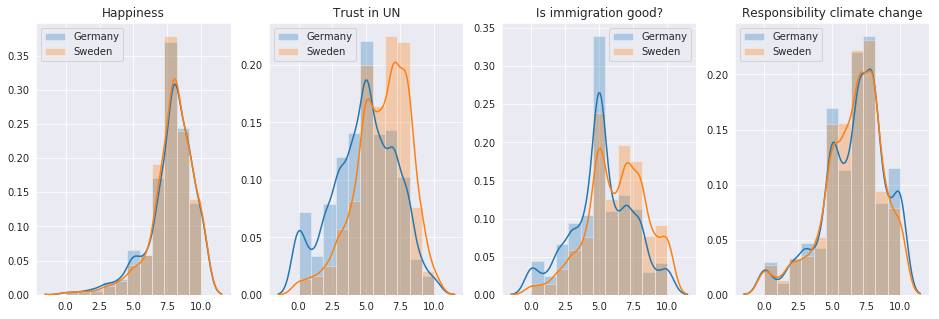

In [17]:
# plot the data we want to perform tests on
fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=1,ncols=4,figsize=(16,5))
for var, ax, title in zip(["happy","trstun","imwbcnt","ccrdprs"],[ax1, ax2, ax3, ax4],
                   ["Happiness","Trust in UN","Is immigration good?","Responsibility climate change"]):
    # get data
    de = ess.loc[ess.cntry=="DE",var]
    se = ess.loc[ess.cntry=="SE",var]
    
    # make plots
    sns.distplot(de,bins=11,kde=True,hist_kws={"alpha":0.3}, kde_kws={"bw":0.5},ax=ax,label="Germany")#color="lightblue"
    sns.distplot(se,bins=11,kde=True,hist_kws={"alpha":0.3}, kde_kws={"bw":0.5},ax=ax,label="Sweden")
    ax.set_xlabel("")
    ax.legend()
    ax.set_title(title)

We can see that our raw data from our samples is definitely not distributed normally in most cases. But the t-test works with the sample means, so how are the means distributed? According to the [central limit theorem](https://en.wikipedia.org/wiki/Central_limit_theorem), sample means tend to be normally distributed around the population mean for sufficiently large sample sizes, even if the underlying distribution is not normal. Let's try to understand that by randomly sampling 5, 10, 50, and 500 answers from the Germany happiness data 10000 times and looking at the histograms.

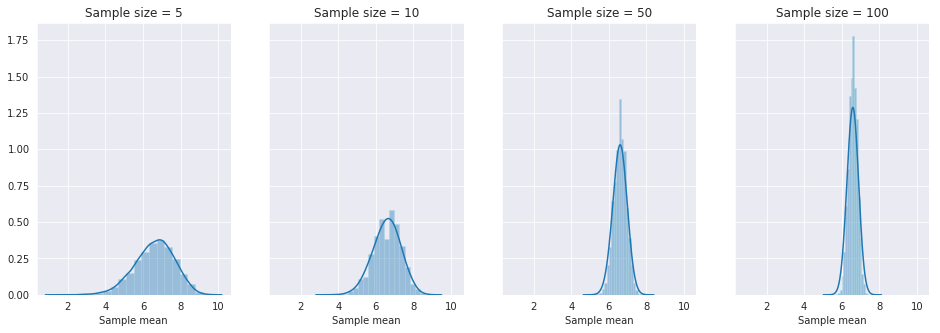

In [18]:
# prepare a figure
fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=1,ncols=4,figsize=(16,5),sharex=True,sharey=True)

# get the data
happy_de = ess.loc[(ess.cntry=="DE")&~(ess[var].isna()),var]
# determine sample sizes
sample_size = [5, 10, 50, 100]

for n, ax in zip(sample_size,[ax1, ax2, ax3, ax4]):
    
    # for each sample size, simulate 10000 random sampels and calculate their means
    means = []
    for i in range(0,10000):
        sample = np.random.choice(happy_de, size=n, replace=True)
        mean = np.mean(sample)
        means.append(mean)
    
    # plot the distribution of sample means for each sample size
    sns.distplot(means,bins=20,kde=True,hist_kws={"density":True,"ec":"lightblue"}, kde_kws={"bw":0.2},ax=ax,)
    ax.set_xlabel("Sample mean")
    ax.set_title(f"Sample size = {n}")

We can clearly see in the histograms above that for smaller sample sizes, the skew of the underlying sampling distribution is still visible, but for larger sample sizes, the sample means are practically normally distributed. We should keep in in mind though that the mean is not always the best measure of the central tendency for all kinds of data. Even if the central limit theorem holds, if the underlying distribution of the data is strongly skewed, maybe the median is a much better representation of central tendency and then a non-parametric test would be the way to go.

In [19]:
m = np.mean([ess[ess.cntry==c].shape[0] for c in ess.cntry.unique()])
print(f"Countries' mean sample size: {m:.2f}")

Countries' mean sample size: 1929.48


We are lucky to have a very large sample size. And due to the fixed answer scales in this survey, we can exclude the presence of strong outliers which could distort the calculated mean. Hence, we can probably savely assume that the normallity assumption is met in our example.
But what should we do if this assumption was not met, e.g. if our sample size was too small or the sample distribution exhibits outliers, skewness, or heavy-tails? This is often overlooked and I want to quote a great [blog post](https://garstats.wordpress.com/2016/05/02/robust-effect-sizes-for-2-independent-groups/) here, saying *"When I was an undergrad, I was told that beyond a certain sample size (n=30 if I recall correctly), t-tests and ANOVAs are fine.* ***This was a lie.***"

The are more robust alternatives called non-parametric rank-based test. They're called like that because they do not make assumptions of the shape of the underlying distribution and instead compare the ranks of different groups. A non-parametric alternative to the two sample t-test is the [Mann-Whitney U test](https://en.wikipedia.org/wiki/Mann%E2%80%93Whitney_U_test), which tests if one group is stochastically greater than the other. It does so by ranking the data from both groups and calculating how often any obervation from one group is higher in rank than any obervation from the other group. This ranksum is the U statistic, which is approximately normally distributed and, hence, can be assigned a z-score and a corresponding p-value. For assuming this distribution of U under the null, the test does also assume equal variance of the samples' underlying populations. Have a look [here](http://www.statisticslectures.com/topics/mannwhitneyu/) for an example.

Let me show you that the Mann-Whitney U test will yield approximatley the same result as a t-test on ranked normallly distributed data.

In [20]:
from scipy.stats import ttest_ind, mannwhitneyu, rankdata

# make some random data
a = np.random.normal(0.0, 1.0, size=1000)
b = np.random.normal(0.1, 1.0, size=1000)
# perform a Mann-Whitney U test, the continuity correction should only be 
# applied for non-continoius data to handle ties
U, p_mw =  mannwhitneyu(a,b,use_continuity=False,alternative="two-sided")

#rank data
ranked = rankdata(np.append(a,b),method="average")
ranked_a = ranked[:len(a)]
ranked_b = ranked[len(a):]
# perform a t-test on ranks
t, p_t = ttest_ind(ranked_a,ranked_b,equal_var=True)

print(f"Mann-Whitney U test p-value: {p_mw}\nt-test p-value: {p_t}")

Mann-Whitney U test p-value: 0.0023639824960439253
t-test p-value: 0.0023453585205759023


I want to use both the t-test and the Mann-Whitney U test her to compare their results. The p-value will help us in deciding if we want to consider a difference between the groups as statistically significant or not but it does not tell us how large the difference is. Since the answers in the survey don't have a common unit, it makes sense to look at standardized effect sizes. 

A standardized difference in means can be expressed by [Cohen's $d$](https://en.wikipedia.org/wiki/Effect_size#Cohen's_d), the difference in group means divided by the pooled standard deviation. It assumes equality of variance as well, and can be positively biased for small samples which shouldn't be a problem here. It has a less biased cousin called [Hedge's $g$](https://en.wikipedia.org/wiki/Effect_size#Hedges'_g) which is, however, not used as commonly. I will use $d$ here because there are well accepted descriptors for magnitudes: 0.2 is considered small, 0.5 medium, and 0.8 large of an effect. Note that these are just conventional benchmarks and that a different interpretation may make sense in some cases.

An effect size coming directly out of the Mann-Whitney U test is called the [common language effect size](https://en.wikipedia.org/wiki/Mann%E2%80%93Whitney_U_test#Common_language_effect_size), $f = \frac{U}{nm}$, where n and m are the sizes of the two groups. It basically tells you, out of all pairs between both groups, the proportion of pairs that support one group being stochastically greater than the other. A value of 0.5 means the groups are stochastically equal and a value of 1.0 means one group is fully greater than the other. This is actually the same metric as the area under the receiver operating curve (AUC-ROC), which is commonly used to evaluate machine learning models. We can also define a rank biserial correlation as $r = 1 - \frac{2U}{n m}$. If we'd treat this correlation like a Pearson's correlation, we could transform it into a Cohen's $d$ as $d =  \frac{2r}{\sqrt{1-r^{2}}}$. Please note that I'm not really confident if that last move can actually be done with a rank biserial correlation and I just want to use it for comparison here - don't quote me on this.


In [21]:
# I need to quickly modify Scipy.stats' mannwhitneyu function so that it returns 
# the U statistic for both groups, not just the smaller one

from scipy.stats import tiecorrect, distributions
def mannwhitneyu(x, y, use_continuity=True, alternative=None):
    """
    EDIT: My modified version that returns the U statistic for both groups, 
          not just the smaller one
    
    Compute the Mann-Whitney rank test on samples x and y.
    Parameters
    ----------
    x, y : array_like
        Array of samples, should be one-dimensional.
    use_continuity : bool, optional
            Whether a continuity correction (1/2.) should be taken into
            account. Default is True.
    alternative : None (deprecated), 'less', 'two-sided', or 'greater'
            Whether to get the p-value for the one-sided hypothesis ('less'
            or 'greater') or for the two-sided hypothesis ('two-sided').
            Defaults to None, which results in a p-value half the size of
            the 'two-sided' p-value and a different U statistic. The
            default behavior is not the same as using 'less' or 'greater':
            it only exists for backward compatibility and is deprecated.
    Returns
    -------
    statistic : float
        The Mann-Whitney U statistic, equal to min(U for x, U for y) if
        `alternative` is equal to None (deprecated; exists for backward
        compatibility), and U for y otherwise.
        
    U1: The Mann-Whitney U statistic for x
    
    U2: The Mann-Whitney U statistic for y
    
    pvalue : float
        p-value assuming an asymptotic normal distribution. One-sided or
        two-sided, depending on the choice of `alternative`.
    Notes
    -----
    Use only when the number of observation in each sample is > 20 and
    you have 2 independent samples of ranks. Mann-Whitney U is
    significant if the u-obtained is LESS THAN or equal to the critical
    value of U.
    This test corrects for ties and by default uses a continuity correction.
    References
    ----------
    .. [1] https://en.wikipedia.org/wiki/Mann-Whitney_U_test
    .. [2] H.B. Mann and D.R. Whitney, "On a Test of Whether one of Two Random
           Variables is Stochastically Larger than the Other," The Annals of
           Mathematical Statistics, vol. 18, no. 1, pp. 50-60, 1947.
    """
    if alternative is None:
        warnings.warn("Calling `mannwhitneyu` without specifying "
                      "`alternative` is deprecated.", DeprecationWarning)

    x = np.asarray(x)
    y = np.asarray(y)
    n1 = len(x)
    n2 = len(y)
    ranked = rankdata(np.concatenate((x, y)))
    rankx = ranked[0:n1]  # get the x-ranks
    u1 = n1*n2 + (n1*(n1+1))/2.0 - np.sum(rankx, axis=0)  # calc U for x
    u2 = n1*n2 - u1  # remainder is U for y
    T = tiecorrect(ranked)
    if T == 0:
        raise ValueError('All numbers are identical in mannwhitneyu')
    sd = np.sqrt(T * n1 * n2 * (n1+n2+1) / 12.0)

    meanrank = n1*n2/2.0 + 0.5 * use_continuity
    if alternative is None or alternative == 'two-sided':
        bigu = max(u1, u2)
    elif alternative == 'less':
        bigu = u1
    elif alternative == 'greater':
        bigu = u2
    else:
        raise ValueError("alternative should be None, 'less', 'greater' "
                         "or 'two-sided'")

    z = (bigu - meanrank) / sd
    if alternative is None:
        # This behavior, equal to half the size of the two-sided
        # p-value, is deprecated.
        p = distributions.norm.sf(abs(z))
    elif alternative == 'two-sided':
        p = 2 * distributions.norm.sf(abs(z))
    else:
        p = distributions.norm.sf(z)

    u = u2
    # This behavior is deprecated.
    if alternative is None:
        u = min(u1, u2)
        
    return u, u1, u2, p


### Performing test <a id="stats2"></a>
<a id="tests" ></a>
Now let's finally perform the tests. We start with a Leven's test for equal variances on the previous mentioned examples. If the p-values falls below our chosen significance level of 0.05, we will assume that the variances of the samples are unequal.

In [22]:
from scipy.stats import levene
# perform Leven's test on the samples of interest
for var in ["happy","trstun","imwbcnt","ccrdprs"]:
    a = ess.loc[(ess.cntry=="DE")&~(ess[var].isna()),var]
    b = ess.loc[(ess.cntry=="SE")&~(ess[var].isna()),var]
    stat, p = levene(a,b)
    print(f"p-value for Leven's test on variable {var}: {p}")

p-value for Leven's test on variable happy: 0.04897068764262911
p-value for Leven's test on variable trstun: 2.0311968228602714e-08
p-value for Leven's test on variable imwbcnt: 0.006296412299982697
p-value for Leven's test on variable ccrdprs: 0.10995168268972666


For all but the last test, the p-value is lower than 0.05 so we should generally consider inequality of variances. For the t-test that means that we'll use Welch's version instead of the Student's version. For the Mann-Whitney U test that unfortunately means that an assumption is violated in a way we cannot fix.

In [23]:
# implement the function for the tests
def stats_tests(country_a="Germany", country_b="Sweden", 
                var_list=["happy","trstun","imwbcnt","ccrdprs"],
                alpha=0.05):
    """
    Performs Welch's t-test and Mann-Whitney U test on two countrie's 
    answers to the questions corresponding to the supplied variables.
    
    Parameters
    ----------
    country_a, country_b : string,
            Names of the countries to compare
    var_list : list of strings
            List with variable names to compare
    alpha : float in range [0,1]
            Significance level alpha
    
    Returns
    -------
    None, just prints the results
    """
    
    cntry_dict = dict(zip(
                          ["Austria","Belgium","Switzerland","Czech republic","Germany",
                           "Estonia","Spain","Finland","France","United Kingdom","Hungary",
                           "Ireland","Israel","Iceland","Italy","Lithuania","Netherlands",
                           "Norway","Poland","Portugal","Russia","Sweden","Slovenia"],
                          ['AT', 'BE', 'CH', 'CZ', 'DE', 'EE', 'ES', 'FI', 'FR', 'GB', 
                           'HU','IE', 'IL', 'IS', 'IT', 'LT', 'NL', 'NO', 'PL', 'PT', 
                           'RU', 'SE','SI']))
    
    # adjust significance level alpha with the Bonferoni correction
    alpha_cor = alpha / len(var_list)
    
    # for each comparison
    for var in var_list:
        # get data (without NaNs)
        a = ess.loc[(ess.cntry==cntry_dict[country_a])&~(ess[var].isna()),var]
        b = ess.loc[(ess.cntry==cntry_dict[country_b])&~(ess[var].isna()),var]

        # sample sizes
        n = len(de)
        m = len(se)
        
        # perform Welch's version of the t-test to account for possibly unequal variances
        t, p_t = ttest_ind(a, b, equal_var=False)
        # calculate Cohen's d from t statistic
        d_t = t * np.sqrt(((n+m)/(n*m))*((n+m)/(n+m-2)))
        
        # We could also calculate d directly but this way there would be no correction 
        # for unequal variance which I hope is accounted for through Welch's t-test. 
        # The differences are negligible anyway, usually in the order of +/- 0.005.
        # s = np.sqrt(((n-1)*np.var(a)+(m-1)*np.var(b))/(n+m))
        # d = (np.mean(a)-np.mean(b))/s
        
        # perform Mann-Whitney U test with continuety corrertion
        U, U1, U2, p_mw = mannwhitneyu(a, b, use_continuity=False,alternative="two-sided")
        # calculate common language effect size
        f = U1/(n*m)
        # calculate rank biserial correlation
        r = 1- (2*U1/(n*m))
        # convert r to d (don't do this step for your own research without consulting a statistician)
        d_mw = 2*r/np.sqrt(1-r**2)
        
        # print the test results
        print("#----------------------------------------------------------------#")
        question = variables.query("Name == @var").Label.values[0]
        print(f"Question: {question}")
        print(f"Tests for {country_a} vs. {country_b} at significance level alpha={alpha}\n\
Bonferroni-corrected alpha: {alpha_cor}\n")
        print(f"Results of two-independent-sample Welch's t-test:\nd: {d_t}\np-value: {p_t}")
        if p_t < alpha_cor:
            print("The effect IS statistically significant.\n")
        else:
            print("The effect IS NOT statistically significant.\n")
        print(f"Mann-Whitney U test:\nf: {f}\nd: {d_mw}\np-value: {p_mw}")
        if p_mw < alpha_cor:
            print("The effect IS statistically significant.\n")
        else:
            print("The effect IS NOT statistically significant.\n")
        print("#----------------------------------------------------------------#")


In [24]:
# let's perform tests on the answers of German and Swedish respondents
stats_tests(country_a="Germany",country_b="Sweden", var_list=["happy","trstun","imwbcnt","ccrdprs"],alpha=0.05)

#----------------------------------------------------------------#
Question: How happy are you
Tests for Germany vs. Sweden at significance level alpha=0.05
Bonferroni-corrected alpha: 0.0125

Results of two-independent-sample Welch's t-test:
d: -0.055016336450354204
p-value: 0.0814180779725071
The effect IS NOT statistically significant.

Mann-Whitney U test:
f: 0.5054074107587205
d: -0.021630908051316983
p-value: 0.33415032425225033
The effect IS NOT statistically significant.

#----------------------------------------------------------------#
#----------------------------------------------------------------#
Question: Trust in the United Nations
Tests for Germany vs. Sweden at significance level alpha=0.05
Bonferroni-corrected alpha: 0.0125

Results of two-independent-sample Welch's t-test:
d: -0.6035233736514466
p-value: 1.508529807853895e-77
The effect IS statistically significant.

Mann-Whitney U test:
f: 0.6056753608107497
d: -0.4324708345379035
p-value: 1.4695150972378358e-71
T

The two types of tests agree on the matter of significance but for the non-significant results, their calculated p-values can be quite different from each other. This is not too surprising considering that we already know that the Mann-Whitney U test's assumption of equal variances is violated and that the two tests are not testing the same null hypothesis (no difference in **means** for the t-test vs. **medians** for the Mann-Whitney U test). Furthermore, parametric tests can have a higher statistical power when the data meets the tests' assumptions because the test then makes use of the knowledge of the underlying distribution. In the case of Welch's t-test, all assumptions seem to be met.

The estimated effect sizes from both types of tests are not too different, differing not more than 0.1 here. The Germans and Swedes who responded in this survey show no statistically significant difference in their happiness or their personal responsibility to reduce climate change. The Swedes, however, think more than the Germans that immigrants make the country a better place to live ($d$ = -0.47, a small to medium effect) and they have more trust in the United Nations ($d$ = -0.61, a medium effect).

Let's try another combination: What do Italians and French think about the question *"How important is it to be successful and that people recognize one's achievements?"*


In [25]:
stats_tests(country_a="Italy",country_b="France", var_list=["ipsuces"],alpha=0.05)

#----------------------------------------------------------------#
Question: Important to be successful and that people recognize achievements
Tests for Italy vs. France at significance level alpha=0.05
Bonferroni-corrected alpha: 0.05

Results of two-independent-sample Welch's t-test:
d: 1.4386826625732236
p-value: 0.0
The effect IS statistically significant.

Mann-Whitney U test:
f: 0.21174931004840972
d: 1.4110979775482093
p-value: 0.0
The effect IS statistically significant.

#----------------------------------------------------------------#


Oh wow! A p-value of zero and $d$ of 1.44, that's a huge effect! Looks like the Italian respondents here care a lot more about being successful and recognized by others.

Now please feel free to check out any question and country combination yourself! In the next section we will try to build machine learning models to predict how people did respond to certain  questions and try to explain these predictions.

## Predicting answers with machine learning <a id="ml"></a>
We have seen in the previous sections that people who answer some questions in a certain way also seem likely to answer other questions in a specific way. There seem to be certain types of personalities, attitudes, or opinions which can be observed among the respondents of the survey. Can we make use of these patterns to make a prediction of how people feel about something, based on the answers they have given? 

In this example, I want to see if I can predict how happy respondents rate themselves. This is a regression problem for which machine learning algorithms come in handy. Usually we'd also like to know what factors are relevant for a prediction. In linear models we can access such information relatively easily, but often linear models are not complex enough to model complex relationships in the data. On the contrary, modern ensemble algorithms are much more powerful predictors but their internal complexity often makes it hard to explain their predictions and they're often described as black-box models. Interpretability can be a very important factor though, and EU regulations even demand a [right to explanation](https://ora.ox.ac.uk/catalog/uuid:593169ee-0457-4051-9337-e007064cf67c/download_file?file_format=pdf&safe_filename=euregs.pdf&type_of_work=Journal+article) for algorithmic decision making. To quote another [blogpost](https://towardsdatascience.com/explain-your-model-with-the-shap-values-bc36aac4de3d): *"If you ask me to swallow a black pill without telling me what’s in it, I certainly don’t want to swallow it. The interpretability of a model is like the label on a drug bottle."*

I will compare both approaches here and try to provide explanations for predictions by using [SHAP values](http://papers.nips.cc/paper/7062-a-unified-approach-to-interpreting-model-predictions.pdf).

### Data preparation <a id="ml1"></a>
Now we have to think about how to prepare the data for machine learning. Let's think about outliers first. In the data from the x to y scale kind of answers, we won't have any outliers. But the four continuous variables, news consumption, internet usage, age, and years of education, could contain outliers. We will detect them visually below.

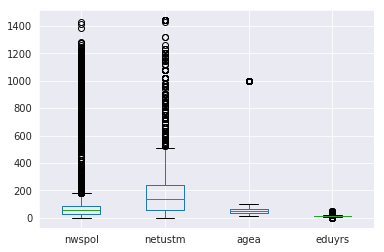

In [26]:
# detect outliers for the continuous variables
_ = ess[variables.query("Scale_type == \"continuous\"").Name].plot(kind="box")

The outliers for the variables `nwspol` (news consumption), `netustm` (internet usage), and `eduyrs` (years of education) probably make sense and we should not delete them. Some people just like to browse or study a lot and that is important information. But certainly no one is 1000 years old, so we'll remove everything above say 100 years of age. We should also remove the entire varible `stflife` corresponding to the question *"How satisfied with life as a whole?"* because it is almost identical with *"How happy are you?"* and, therefore, represents a source of [data leakage](https://www.quora.com/Whats-data-leakage-in-data-science). Last but not least, all rows with missing label (happiness value) have to be dropped.

In [27]:
# remove age outlier
ess.agea.where(ess.agea<100,np.NaN,inplace=True)

# remove variable stflife
ess.drop("stflife",axis=1,inplace=True)

# remove rows with missing happiness value
ess = ess[~ess.happy.isna()]

Let's now split off a hold-out set from our data. Since not all countries and genders have the same number of respondents (see plot below) we should stratify the split so that both the training and test data contain a similar fraction from each country and gender.

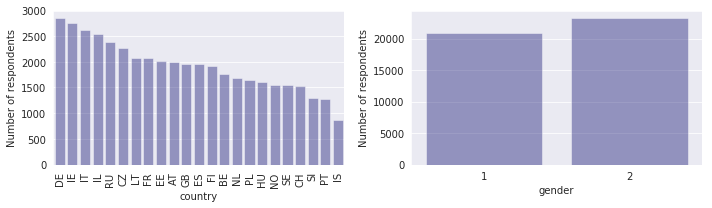

In [28]:
# plot respondents per country
fig, (ax1, ax2) = plt.subplots(nrows=1,ncols=2,figsize=(10,3))
sns.barplot(ess.cntry.value_counts().index, ess.cntry.value_counts(),color="navy",alpha=0.4,ax=ax1)
sns.barplot(ess.gndr.value_counts().index,ess.gndr.value_counts(),color="navy",alpha=0.4,ax=ax2)
ax1.set_xticklabels(ax1.get_xticklabels(),rotation="vertical")
ax1.set_xlabel("country")
ax2.set_xlabel("gender")
for ax in [ax1,ax2]:
    ax.set_ylabel("Number of respondents")
plt.tight_layout()

In [29]:
# do a stratified split of training and test data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(ess.drop("happy",axis=1), 
                                                    ess.happy, 
                                                    stratify=ess[["cntry","gndr"]], 
                                                    test_size=0.25, random_state=42)

There are still about 150 variables left. Many of these are probably not strongly correlated with a person's happiness. It may make sense to remove uninformative features because it will reduce the computational cost and reduce the dimensionality of the data. The more dimensions are considered, the less densely populated the feature space will be. That means that new data is likely to be further away from learned training examples, which can make prediction harder. This problem is also known as the [curse of dimensionality](https://en.wikipedia.org/wiki/Curse_of_dimensionality#Machine_learning).
We can calculate Pearson's correlation and have a look how many features are at least weakly correlated with happiness:

In [30]:
# calculate correlation
cor = ess.corr().happy
highcor = cor[np.abs(cor)>=0.15].sort_values()
print(f"{len(highcor)} out of {len(cor)} features have a correlation with happiness >= 0.15")

49 out of 154 features have a correlation with happiness >= 0.15


Removing features may not necissarily yield in a large increase in prediction quality but it will simplify the problem and, considering we are also interested in explaining which features are particulary important in predicting happiness, I think it makes sense here. If only dimensionality reduction was of interest, one could also apply unsupervised machine learning methods such as [principal component analysis](https://en.wikipedia.org/wiki/Principal_component_analysis), but we will not consider this here.

There are different approaches to feature selection. Some models offer ways (e.g. feature importance from decision trees or coefficients from [Lasso](https://en.wikipedia.org/wiki/Lasso_(statistics)-regularized linear regression) to select important features, but this requires training another model before the actual model. A simpler way is given by univariate statistical tests on the individual features, which do not take any feature interactions into account. This is what we'll do here by, say, selcting the 50 highest scoring features.

We will already perfrom One-Hot encoding on the categorical variables (country and gender) at this point using Panda's `get_dummies()` function rather than Scikit-Learn's `OneHotEncoder`.

In [31]:
X_train = pd.get_dummies(X_train,columns=["cntry","gndr"])
X_test = pd.get_dummies(X_test,columns=["cntry","gndr"])



Next, we should also consider standardizing (scale to zero mean and unit variance) the data because linear models tend to work better with data on similar scales and this way we will also be able to directly compare the coefficients from the linear model and use them as a measure of feature importance. For tree-based methods (as in the gradient boosted ensemble we will use later) this should not matter, but I should not hurt either. The default `StandardScaler` in Sci-kit Learn is not very robust to outliers though; therefore, we will use a `PowerTransformer` instead, which transforms the data into a Gaussian-like shape and also applies zero-mean-unit-variance normalization. 

Regarding all the missing values (NaNs), we have two options: We could either drop the rows containing missing values or impute  them. Dropping would mean that we would lose not only one answer but an entire respondent who may have given valid answers to many  other questions, so I would first try to impute the values. Since we've already seen before that some answers are distributed in a rather skewed  way, I will impute missing values with the column median rather than the mean.

In [32]:
from sklearn.preprocessing import PowerTransformer
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# get column/variable names for the different preprocessing operations
num = X_train.loc[:,"nwspol":"impfun"].columns
cat = X_train.loc[:,"cntry_AT":"gndr_2"].columns

# set up the preprocessing pipeline with imputing and power-tranforming for numerical values
preprocessing = ColumnTransformer(transformers=[
    ("numpipe",Pipeline(steps=[
              ("impute",SimpleImputer(strategy="median")),
              ("transform",PowerTransformer(standardize=True))    
                           ]),num),
    ("onehot","passthrough",cat)
])


# since we do not have any hyper-parameters to tune within the preprocessing,
# we will preprocess the data here and not within a single complete pipeine
# so that we save time in the gridsearch
X_train_prep = pd.DataFrame(preprocessing.fit_transform(X_train), columns=X_train.columns, index=X_train.index)
X_test_prep = pd.DataFrame(preprocessing.transform(X_test), columns=X_test.columns,index=X_test.index)


We need a way to recover the names of the features that have been selected:

In [33]:
select = SelectKBest(score_func=f_regression,k=50).fit(X_train_prep,y_train)
# get the indices of the 50 highest scores
idx = select.scores_.argsort()[-50:] 
# get the corresponding feature names
selected_features = X_train_prep.columns[idx]
print(selected_features)

Index(['impfun', 'cflsenr', 'iorgact', 'hmsacld', 'ipcrtiv', 'cptppola',
       'cntry_RU', 'trstun', 'psppsgva', 'impcntr', 'iphlppl', 'imsmetn',
       'imdfetn', 'slvuemp', 'hhmmb', 'lkuemp', 'iplylfr', 'psppipla',
       'trstprt', 'hmsfmlsh', 'trstplt', 'atchctr', 'wkdcorga', 'atcherp',
       'freehms', 'aesfdrk', 'netusoft', 'sclact', 'imbgeco', 'hinctnta',
       'stfgov', 'pplhlp', 'trstprl', 'hlthhmp', 'imueclt', 'trstlgl',
       'inprdsc', 'ppltrst', 'sclmeet', 'imwbcnt', 'slvpens', 'stfedu',
       'pplfair', 'trstplc', 'stfhlth', 'stfdem', 'lknemny', 'stfeco',
       'hincfel', 'health'],
      dtype='object')


### Interpretation of linear models <a id="ml2"></a>
With all the neccessary preprocessing in place, we can train the first model. Let's start with a elastic-net-regularized linear regression.

In [34]:
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import GridSearchCV

# combine the feature selection with the regression model
regressor = Pipeline(steps=[
    ("select",SelectKBest(score_func=f_regression,k=50)),
    ("reg",ElasticNet(random_state=42)),
])

# hyper-parameter options for optimization
param_grid = {"reg__alpha": np.logspace(-3,2,6),
              "reg__l1_ratio": [0.0,0.25,0.5,0.75]}

# perform a grid search cross validation for hyper-paramter optimization
lin_grid = GridSearchCV(regressor,param_grid=param_grid,
                        scoring="neg_mean_absolute_error", 
                        n_jobs=-1, iid=False, 
                        cv=5,verbose=0).fit(X_train_prep,y_train)

How did the linear model perform? 

In [35]:
from sklearn.metrics import mean_absolute_error

ypred = lin_grid.predict(X_test_prep)
test_err = mean_absolute_error(y_test, ypred)
print(f"Best parameters: {lin_grid.best_params_}\n\
Cross-validation mean absolute error: {-1*lin_grid.best_score_}\n\
Test mean absolute error: {test_err}")

Best parameters: {'reg__alpha': 0.01, 'reg__l1_ratio': 0.25}
Cross-validation mean absolute error: 1.1550813768624484
Test mean absolute error: 1.1353186284187047


The linear model has a mean absolute error around 1.1 to 1.2 when predicting happiness on a scale of 0 to 10. That's not a bad start, we'll see if we can do better later on. Which features seem to be contributing the most or least to people's happiness? In linear models we can directly look at the coefficients: 

In [36]:
# get features that were selected 
selected_features = X_train_prep.columns[lin_grid
                                         .best_estimator_
                                         .named_steps['select']
                                         .scores_.argsort()[-50:]].tolist()

# bring them in the right order so that they'll match the coefficients' order
ordered_features = [f for f in X_train_prep.columns if f in selected_features]

# the selected dummy variable "cntry_RU" doesn't exist is the variables data frame yet so we add it
variables = variables.append(
    pd.DataFrame(np.array(["cntry_RU","Living in Russia",None,None,None,None,None,None,None,None,]).reshape(-1,10),
                 columns=variables.columns),
    ignore_index=True
) 

# get the trained model's coefficients
coef = lin_grid.best_estimator_.named_steps['reg'].coef_

# put it all in a data frame
features = pd.DataFrame(sorted(zip(coef,
                                   ordered_features,
                                   variables.query("Name in @ordered_features").Label,),
                               reverse=True),
                        columns=["coefficient","feature","question"])

# look at the two happiest and two saddest features
features.iloc[[0,1,2,-3,-2,-1]]

,coefficient,feature,question
0,0.247130,health,Subjective general health
1,0.219648,stfeco,How satisfied with present state of economy in...
2,0.213510,atchctr,How emotionally attached to [country]
47,-0.076225,trstplt,Trust in politicians
48,-0.098587,hlthhmp,Hampered in daily activities by illness/disabi...
49,-0.135400,lknemny,How likely not enough money for household nece...


We can see above that the two most important features that contribute to people feeling happy are their health and their satisfaction with the present state of the economy. On the other hand, being hampered by illness and worrying about not having enough money for household necessities is contributing to people being sad. That's not surprising overall, but I find it very interesting to see how much each factor contributes.
There actually is a handy Python library called `eli5` which can give you this information more easily by just supplying it with the trained estimator and the feature names (it will also show the coefficient for the intercept called `<BIAS>`):

In [37]:
import eli5
eli5.show_weights(lin_grid.best_estimator_,feature_names=X_train_prep.columns.values)

Weight?,Feature
+7.441,<BIAS>
+0.247,health
+0.220,stfeco
+0.214,atchctr
+0.186,hhmmb
+0.184,hincfel
+0.155,trstplc
+0.126,stfedu
+0.123,sclmeet
+0.103,sclact


Using the fitted coefficients, we can also see how each answer of an individual respondent contributes to their predicted happiness score. Let's have a look at a random person:

In [38]:
# eli5 can't predict with pipelines so we'll do the feature selection and model train again manually
select = lin_grid.best_estimator_.named_steps['select']
X_train_sel = pd.DataFrame(select.transform(X_train_prep),columns=ordered_features,index=X_train_prep.index)
lin_reg = ElasticNet(alpha=0.01, l1_ratio=0.25,random_state=42).fit(X_train_sel,y_train)
feature_names = variables.query("Name in @ordered_features").Label.values

# explain the score prediction for respondent 30092
eli5.show_prediction(lin_reg, X_train_sel.iloc[30092], top=(4,3), feature_names=feature_names)

Here we can see that this respondent is made happy by her/his satisfaction in the present state of the economy but that her/his (presumably low) trust in the police is reducing the predicted happiness. 

These calculations are very informative and straightforward because they directly "fall out" of the linear model. The values of a feature's coefficient informs us about the feature's impact. In high-performing, more complicated models like tree-based ensembles or deep neural networks, there is no more direct one-to-one relationship between an input features and the model's trained parameters. This makes it difficult to understand the overall impact of features and individual predictions. 

There are, however, general approaches for explaining any kind of machine learning model by making the explanation a model itself. A very powerful concept are SHAP (SHapley Additive exPlanations) values. The idea is the following: How do we know how much each individual feature value contributes to the value of a prediction? We have to calculate each feature's marginal contribution for every possible permutation of features. The average of all these marginal contributions is the SHAP value. For more details (an the math), please refer to the [original paper](http://papers.nips.cc/paper/7062-a-unified-approach-to-interpreting-model-predictions.pdf). Let's try this concepts for the linear model. Since the calculation of SHAP values is quite time-consuming, we will demonstrate it on a smaller subset of the training data.

In [40]:
import shap
# shap uses javascript
shap.initjs()


# get 100 random index numbers as our random sample
np.random.seed(42)
rnd = np.random.randint(0,X_train_sel.shape[0],100)

# create an explainer and calculate SHAP values for our sample
exp = shap.KernelExplainer(lin_reg.predict,X_train_sel.iloc[rnd],l1_reg="num_features(50)")
shap_values = exp.shap_values(X_train_sel.iloc[rnd])

In [41]:
# save the explanation model and shap values bc it takes long to calculate
import pickle
pickle.dump(exp,open(b"SHAP.exp","wb"))
pickle.dump(shap_values,open(b"SHAP.val","wb"))

In [42]:
# load the explanation model and shap values
#import pickle
#exp =  pickle.load(open("SHAP.exp","rb"))
#shap_values = pickle.load(open("SHAP.val","rb"))

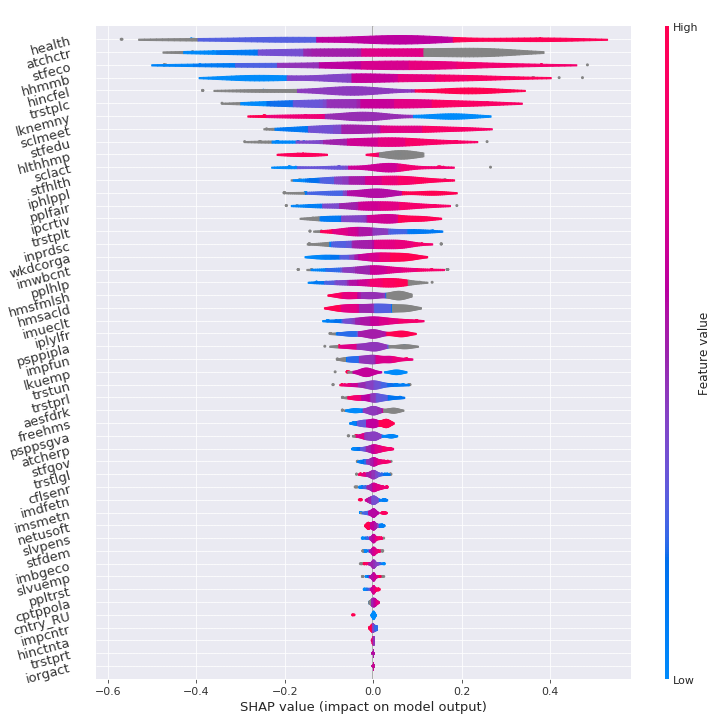

In [43]:
# plot the calculated SHAP values
fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(12,12))
plt.yticks(rotation=15)
shap.summary_plot(shap_values, X_train_sel.iloc[rnd],
                  max_display=50, auto_size_plot=False, 
                  plot_type="violin")

For all examples, SHAP values of all features were calculated. A high SHAP value (colored red) means that in the corresponding example, the value of the feature contributed positively to the calculated score, compared to a baseline score (in this case, average happiness of all respondents in the sample). We can now see that the features which have a high impact also have high absolute SHAP values. For example, the `health` feature has highly positive and highly negative SHAP values. This is because a high value of `health` (people feeling more healthy) contributes strongly to their happiness, whereas a low value of `health` (people feeling unhealthy) makes them feel less happy. As before we may want to have a look at individual predictions to see how respondents' individual answers contribute to their predicted happiness score:

In [44]:
# display the original and transformed values of the answers to features/questions 
# with high SHAP value for one of the randomly sampled respondents
i = 5
idx = X_train_sel.iloc[rnd].iloc[i].name
high_SHAP_feats = [v for s,v in sorted(zip(np.abs(shap_values[i,:]),
                                           X_train_sel.columns.tolist()),
                                       reverse=True)][:15]
X_train.loc[[idx]].append(X_train_sel.loc[[idx]])[high_SHAP_feats].head()

,health,stfeco,stfedu,trstplc,iphlppl,sclmeet,lknemny,hlthhmp,stfhlth,sclact,pplfair,inprdsc,trstplt,wkdcorga,atchctr
43595,1.000000,0.000000,1.000000,3.00000,2.000000,2.000000,1.000000,3.000000,0.000000,4.000000,2.000000,0.000000,0.000000,0.000000,9.000000
43595,-2.420841,-2.083101,-1.962981,-1.43188,-2.153134,-1.686221,-1.279594,1.777702,-2.070107,1.429339,-1.671648,-2.061476,-1.646384,-1.766708,0.526941


In [45]:
# explain a single prediction for one of the randomly sampled respondents
shap.force_plot(exp.expected_value, shap_values[i,:], X_train_sel.iloc[rnd].iloc[i])

As we can see above, this respondent does not feel particularly happy. Her/his low subjective `health`, low satisfaction with the present state of the economy (`stfeco`) and education (`stfedu`) make her/him feel less happy, whereas, little worries about lack of money for household neccassities (`lknemny`) and frequent participation in social activities (`sclact`) make her/him more happy. Now that we have a universal way to explain the impact of our features for the overall model as well as for individual predictions, we can try to get better predictions with more complex models. 


### Interpretation of gradient-boosted ensembles <a id="ml3"></a>
In the following, we will use an ensemble of gradient-boosted decision trees as implemented in the [XGBoost algorithm](https://en.wikipedia.org/wiki/XGBoost). The idea of [gradient-boosting](https://en.wikipedia.org/wiki/Gradient_boosting) is to sequentially train predictors in a way that tries to fit every new predictor to the residual errors of the previous predictor.

In [46]:
from xgboost import XGBRegressor

# combine the feature selection with the XGB regression model
regressor_xgb = Pipeline(steps=[
    ("select",SelectKBest(score_func=f_regression,k=50)),
    ("reg",XGBRegressor(booster="gbtree",n_jobs=4,
                        random_state=42,verbosity=0)),
])

# hyper-parameter options for optimization
# since the gridsearch takes a while, I commented out the non-ideal ones I checked
param_grid = {"reg__max_depth": [5],#[4,5,6],
              "reg__learning_rate":[0.1], #[0.05,0.1,0.15],
              "reg__n_estimators": [125],}#[10,50,75,100,125,150],}

# perform a grid search cross validation for hyper-paramter optimization
xgb_grid = GridSearchCV(regressor_xgb,param_grid=param_grid,
                        scoring="neg_mean_absolute_error", iid=False, n_jobs=1,
                        cv=5,verbose=0).fit(X_train_prep,y_train)

In [47]:
ypred = xgb_grid.predict(X_test_prep)
test_err = mean_absolute_error(y_test, ypred)
print(f"Best parameters: {xgb_grid.best_params_}\n\
Cross-validation mean absolute error: {-1*xgb_grid.best_score_}\n\
Test mean absolute error: {test_err}")

Best parameters: {'reg__learning_rate': 0.1, 'reg__max_depth': 5, 'reg__n_estimators': 125}
Cross-validation mean absolute error: 1.1224201507398217
Test mean absolute error: 1.098073806225703


The XGB model has a mean absolute error around 1.1 when predicting happiness on a scale of 0 to 10, a little bit better than the linear model. In tree-based models, there is also a way to assess feature importance:

In [48]:
# get features that were selected 
selected_features_xgb = X_train_prep.columns[xgb_grid
                                         .best_estimator_
                                         .named_steps['select']
                                         .scores_.argsort()[-50:]].tolist()

# bring them in the right order and get the correspondig questions 
ordered_features_xgb = [f for f in X_train_prep.columns if f in selected_features_xgb]
feature_names_xgb = variables.query("Name in @ordered_features_xgb").Label.values

# because eli5 cannot handle pipelines, train the XGBoost model with the 
# optimized parameeters from grid search cv
select = xgb_grid.best_estimator_.named_steps['select']
X_train_sel_xgb = pd.DataFrame(select.transform(X_train_prep),
                               columns=ordered_features_xgb,
                               index=X_train_prep.index)

xgb_reg = XGBRegressor(booster="gbtree", n_estimators=125,
                       max_depth=5, learning_rate=0.1, n_jobs=4,
                       random_state=42,verbosity=0).fit(X_train_sel_xgb,y_train)

# show the weights associated with the features in the XGBoost model
eli5.show_weights(xgb_reg,feature_names=feature_names_xgb)

Weight,Feature
0.1571,Feeling about household's income nowadays
0.0966,Subjective general health
0.0834,How likely not enough money for household necessities next 12 months
0.0697,How satisfied with present state of economy in country
0.0382,"How often socially meet with friends, relatives or colleagues"
0.0299,Number of people living regularly as member of household
0.0265,How emotionally attached to [country]
0.0234,State of education in country nowadays
0.0228,Important to be loyal to friends and devote to people close
0.0225,Trust in the police


The weights shown here are different from the ones in a linear model. Instead of considering coefficients which scale each features contribution to the predicted score, the feature importance in tree-based models is calculated by considering to how many (decision tree) splits a feature contributes. If many get split by a particular feature, it is considered more important for the prediction. That does, however, not tell if a feature contributes positively or negatively to the predicted value. 

The `eli5` library has a way to estimate each features contribution for a XGBoost model, which is a bit more complex than for a linear model: The feature weights are calculated by back-tracking the decision paths in trees of an ensemble. All feature weights sum up to the predicted score. Each leaf (end of a tree) has an output score from which an expected score can be assigned to its parent node (like a pseudo-leave score). The change of the expected score from parent to child represents the contribution of one feature on the decision path. See this [blogpost](http://blog.datadive.net/interpreting-random-forests/) for more detail. Let's have a look at an individual prediction:

In [49]:
# explain the score prediction for respondent 30092
eli5.show_prediction(xgb_reg, X_train_sel_xgb.iloc[30092], top=(5,4), feature_names=feature_names_xgb)

We can see that similar features as in the linear model contribute to this respondents happiness score but that the order of importance is a little different. In the XGBoost model, satisfaction with the state of education has a  smaller positive contribution, while being hampered by illness has a larger negative contribution than in the linear model.

Luckily, the SHAP values provide a model-agnostic method to evaluate feature contributions. We will calculate them for the XGBoost model on the same sample of respondents as for the linear model to facilitate comparison.

In [50]:
# create an explainer and calculate the XGBoost model's SHAP values for the same sample
exp_xgb = shap.TreeExplainer(xgb_reg,X_train_sel_xgb.iloc[rnd],feature_dependence="independent")
shap_values_xgb = exp_xgb.shap_values(X_train_sel_xgb.iloc[rnd])

In [51]:
# save the XGB explanation model and shap values
import pickle
pickle.dump(exp_xgb,open(b"SHAP.xgb.exp","wb"))
pickle.dump(shap_values_xgb,open(b"SHAP.xgb.val","wb"))

In [52]:
# load the XGBexplanation model and shap values
#import pickle
#exp =  pickle.load(open("SHAP.xgb.exp","rb"))
#shap_values = pickle.load(open("SHAP.xgb.val","rb"))

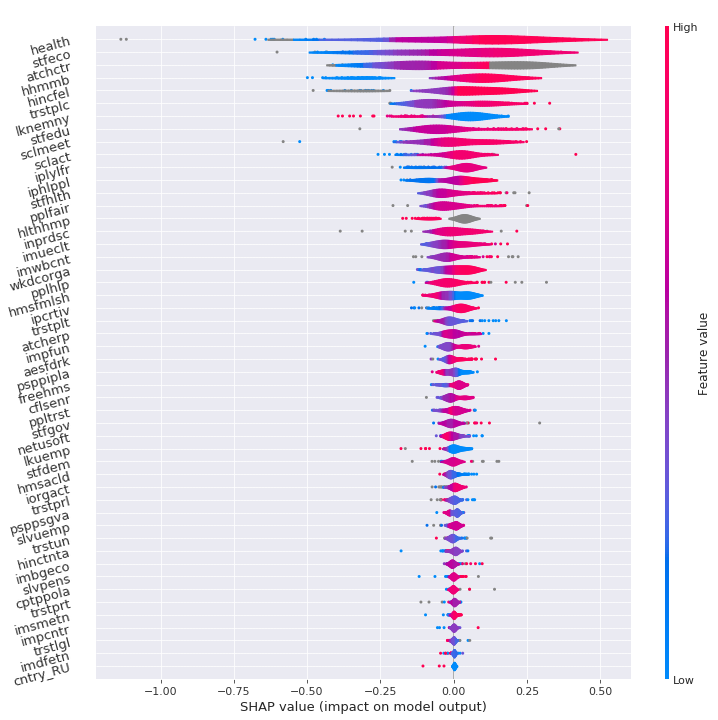

In [53]:
# plot the calculated SHAP values
fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(12,12))
plt.yticks(rotation=15)
shap.summary_plot(shap_values_xgb, X_train_sel_xgb.iloc[rnd],
                  max_display=50, auto_size_plot=False, 
                  plot_type="violin")

Compared to the linear model, the same features are considered important, even though the order is not exactly the same.
What about the individual prediction?

In [54]:
# display the original and transformed values of the answers to features/questions 
# with high SHAP value for one of the randomly sampled respondents
i = 5
idx = X_train_sel_xgb.iloc[rnd].iloc[i].name
high_SHAP_feats = [v for s,v in sorted(zip(np.abs(shap_values_xgb[i,:]),
                                           X_train_sel_xgb.columns.tolist()),
                                       reverse=True)][:15]
X_train.loc[[idx]].append(X_train_sel_xgb.loc[[idx]])[high_SHAP_feats].head()

,health,stfeco,sclmeet,sclact,inprdsc,lknemny,iphlppl,iplylfr,trstplc,hlthhmp,stfdem,hhmmb,trstun,trstplt,slvpens
43595,1.000000,0.000000,2.000000,4.000000,0.000000,1.000000,2.000000,2.000000,3.00000,3.000000,0.000000,3.000000,0.000000,0.000000,0.000000
43595,-2.420841,-2.083101,-1.686221,1.429339,-2.061476,-1.279594,-2.153134,-2.191386,-1.43188,1.777702,-2.027733,0.483008,-1.910358,-1.646384,-1.946657


In [55]:
# explain a single prediction of the XGBoost model for one of the randomly sampled respondents
shap.force_plot(exp_xgb.expected_value, shap_values_xgb[i,:], X_train_sel_xgb.iloc[rnd].iloc[i])

Even though the predicted happiness score is a little lower than for the linear model, the contribution of each feature is more or less identical with the linear model. This is actually really cool, because it shows that SHAP values provide us with a reliable and universally applicable method of explaining arbitrarily complex machine learning models. This does, to some extent, resolve the trade-off between complex but accurate vs. simple but interpretable models.

## Conclusion <a id="conclusion" ></a>

In this work, we have analyzed data from the 8th European Social Survey. We went through a detailed [data cleaning](#data) procedure in which suitable variables corresponding to survey questions were selected, invalid data points were removed, and data scales were adjusted, if necessary. 

We explored how different questions correlate with each other and how the answers are distributed among the participating countries by employing an interactive [visualization](#viz). We saw certain patterns which may be described as attitudes, e.g. positive correlations between xeno- and homophobia, or political and climate responsibility. 

Furthermore, we performed [statistical tests](#stats) to evaluate the statistical significance and effect size of differences in answers of respondents from different countries. We saw, for example, that there is no significant difference in the reported happiness of German and Swedish respondents, whereas there is a very large difference in how important Italian and French respondents consider personal success and recognition.

Finally, we employed [machine learning](#ml) methods to predict how happy respondents considers themselves, based on how they answered other questions. We compared the predictions of linear and gradient-boosted decision tree models in terms of their predictive power and interpretability. We then used SHAP values to explain how each feature contributes to an individual prediction for the two models. Good subjective health, high satisfaction with the present state of the economy, and an emotional attachment to the home country tend to contribute positively to the respondents' happiness. On the contrary, worries about not having enough money for household necessities, or being hampered by illness or disability contributes negatively to the respondents' happiness.

That's it! Thanks a lot for following me through this project and thanks as well to the organizers and participants of this survey and to the developers of the many great open-source tools I used in this project.